In [11]:
import os
import cv2
import numpy as np
import nibabel as nib
import xgboost as xgb
import matplotlib.pyplot as plt

def infer_multimodal(subject_folder, model_path="xgb_model.json"):
    subject_id = os.path.basename(subject_folder)
    flair_path = os.path.join(subject_folder, f"{subject_id}_flair.nii.gz")
    t1_path    = os.path.join(subject_folder, f"{subject_id}_t1.nii.gz")
    t1ce_path  = os.path.join(subject_folder, f"{subject_id}_t1ce.nii.gz")
    t2_path    = os.path.join(subject_folder, f"{subject_id}_t2.nii.gz")
    
    flair = nib.load(flair_path).get_fdata()
    t1    = nib.load(t1_path).get_fdata()
    t1ce  = nib.load(t1ce_path).get_fdata()
    t2    = nib.load(t2_path).get_fdata()
    
    slice_idx = flair.shape[2] // 2
    flair_slice = flair[:, :, slice_idx]
    t1_slice    = t1[:, :, slice_idx]
    t1ce_slice  = t1ce[:, :, slice_idx]
    t2_slice    = t2[:, :, slice_idx]
    
    def process_slice(img_slice):
        image_norm = cv2.normalize(img_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        image_uint8 = image_norm.astype(np.uint8)
        image_resized = cv2.resize(image_uint8, (224, 224)).astype(np.float32)
        return image_resized
    
    flair_processed = process_slice(flair_slice)
    t1_processed    = process_slice(t1_slice)
    t1ce_processed  = process_slice(t1ce_slice)
    t2_processed    = process_slice(t2_slice)
    
    feat = np.array([
        flair_processed.mean(), flair_processed.std(),
        t1_processed.mean(),    t1_processed.std(),
        t1ce_processed.mean(),  t1ce_processed.std(),
        t2_processed.mean(),    t2_processed.std()
    ]).reshape(1, -1)
    
    model = xgb.Booster()   
    model.load_model(model_path)
    
    dmatrix = xgb.DMatrix(feat)
    pred = model.predict(dmatrix)
    return pred

subject_path = "D:/brain_tumor_project/t2/BraTS2021_00005"
#subject_path = "D:/brain_tumor_project/t1/BraTS2021_00495"
prediction = infer_multimodal(subject_path, model_path="xgb_model.json")
label = "Tumor" if prediction[0] >= 0.5 else "No Tumor"
print(f"{os.path.basename(subject_path)} => {label} (score: {prediction[0]:.4f})")



BraTS2021_00005 => No Tumor (score: 0.1126)


BraTS2021_00621 => Tumor (score: 0.9573)


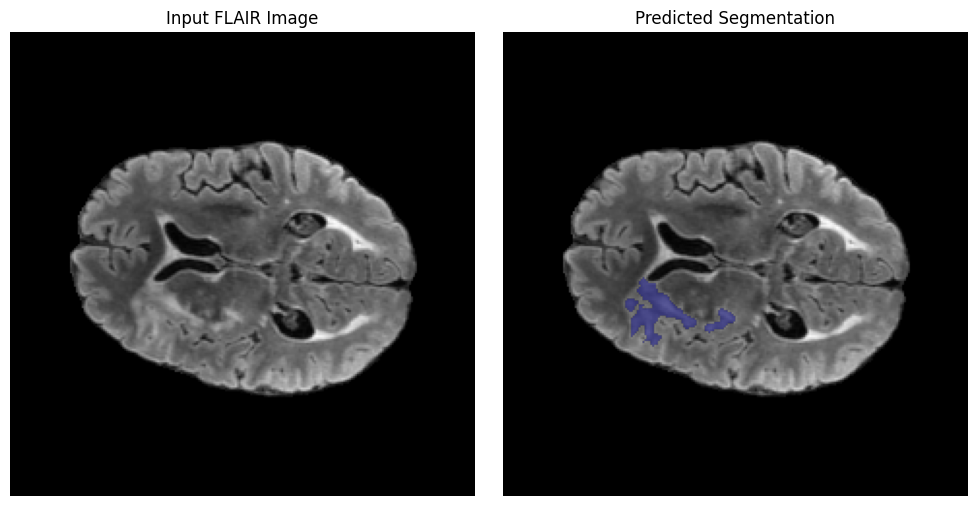

In [3]:
import os
import cv2
import numpy as np
import nibabel as nib
import xgboost as xgb
import matplotlib.pyplot as plt

def infer_multimodal(subject_folder, model_path="xgb_model.json"):
    subject_id = os.path.basename(subject_folder)
    flair_path = os.path.join(subject_folder, f"{subject_id}_flair.nii.gz")
    t1_path    = os.path.join(subject_folder, f"{subject_id}_t1.nii.gz")
    t1ce_path  = os.path.join(subject_folder, f"{subject_id}_t1ce.nii.gz")
    t2_path    = os.path.join(subject_folder, f"{subject_id}_t2.nii.gz")
    
    flair = nib.load(flair_path).get_fdata()
    t1    = nib.load(t1_path).get_fdata()
    t1ce  = nib.load(t1ce_path).get_fdata()
    t2    = nib.load(t2_path).get_fdata()
    
    slice_idx = flair.shape[2] // 2
    flair_slice = flair[:, :, slice_idx]
    t1_slice    = t1[:, :, slice_idx]
    t1ce_slice  = t1ce[:, :, slice_idx]
    t2_slice    = t2[:, :, slice_idx]
    
    def process_slice(img_slice):
        image_norm = cv2.normalize(img_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        image_uint8 = image_norm.astype(np.uint8)
        image_resized = cv2.resize(image_uint8, (224, 224)).astype(np.float32)
        return image_resized
    
    flair_processed = process_slice(flair_slice)
    t1_processed    = process_slice(t1_slice)
    t1ce_processed  = process_slice(t1ce_slice)
    t2_processed    = process_slice(t2_slice)
    
    feat = np.array([
        flair_processed.mean(), flair_processed.std(),
        t1_processed.mean(),    t1_processed.std(),
        t1ce_processed.mean(),  t1ce_processed.std(),
        t2_processed.mean(),    t2_processed.std()
    ]).reshape(1, -1)
    
    model = xgb.Booster()
    model.load_model(model_path)
    
    dmatrix = xgb.DMatrix(feat)
    pred = model.predict(dmatrix)
    return pred

def visualize_modalities(subject_folder):
    subject_id = os.path.basename(subject_folder)
    modalities = ['flair', 't1', 't1ce', 't2']
    
    def load_slice(modality):
        path = os.path.join(subject_folder, f"{subject_id}_{modality}.nii.gz")
        data = nib.load(path).get_fdata()
        mid_slice = data[:, :, data.shape[2] // 2]
        image_norm = cv2.normalize(mid_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        return cv2.resize(image_norm.astype(np.uint8), (224, 224))

    images = [load_slice(mod) for mod in modalities]

    plt.figure(figsize=(12, 3))
    for i, (mod, img) in enumerate(zip(modalities, images)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(mod.upper())
        plt.axis('off')
    plt.suptitle(f"Middle Slice of Modalities for {subject_id}")
    plt.tight_layout()
    plt.show()

def visualize_input_and_prediction(subject_folder):
    subject_id = os.path.basename(subject_folder)
    flair_path = os.path.join(subject_folder, f"{subject_id}_flair.nii.gz")
    seg_path   = os.path.join(subject_folder, f"{subject_id}_seg.nii.gz")

    flair_data = nib.load(flair_path).get_fdata()
    slice_idx = flair_data.shape[2] // 2
    flair_slice = flair_data[:, :, slice_idx]

    flair_img = cv2.normalize(flair_slice, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    flair_img = flair_img.astype(np.uint8)

    seg_slice = np.zeros_like(flair_slice)
    if os.path.exists(seg_path):
        seg_data = nib.load(seg_path).get_fdata()
        seg_slice = seg_data[:, :, slice_idx]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(flair_img, cmap='gray')
    plt.title("Input FLAIR Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(flair_img, cmap='gray')
    plt.imshow(np.ma.masked_where(seg_slice == 0, seg_slice), cmap="jet", alpha=0.5)
    plt.title("Predicted Segmentation")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
subject_path = "D:/brain_tumor_project/t2/BraTS2021_00621"
prediction = infer_multimodal(subject_path, model_path="xgb_model.json")
label = "Tumor" if prediction[0] >= 0.5 else "No Tumor"
print(f"{os.path.basename(subject_path)} => {label} (score: {prediction[0]:.4f})")
visualize_input_and_prediction(subject_path)
